In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for seaborn
sns.set(style="whitegrid")

In [ ]:
file_path = "/content/drive/MyDrive/Colab/NU/CIVE7381/Project/jpl.json"

# Load the JSON data as a list of dictionaries
with open(file_path, 'r') as f:
    data = json.load(f)

# Access the data under the '_items' key
items_data = data['_items']

# Normalize the data:
df = pd.json_normalize(items_data)

# Extract meta data separately:
meta_data = data['_meta']
for key, value in meta_data.items():
    df[key] = value

df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,end,min_kWh,site,start
0,5c36621bf9af8b4639a8e0b4,0001,"Wed, 05 Sep 2018 11:04:13 GMT","Wed, 05 Sep 2018 19:09:35 GMT",None,9.583,1_1_179_800_2018-09-05 11:04:12.876087,0001,AG-3F32,1-1-179-800,America/Los_Angeles,None,None,"Fri, 11 Oct 2024 11:37:00 GMT",None,jpl,"Fri, 01 Jan 2010 11:37:00 GMT"
1,5c36621bf9af8b4639a8e0b5,0001,"Wed, 05 Sep 2018 11:08:09 GMT","Wed, 05 Sep 2018 14:09:02 GMT",None,7.114,1_1_179_794_2018-09-05 11:08:08.945820,0001,AG-3F20,1-1-179-794,America/Los_Angeles,000000333,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...","Fri, 11 Oct 2024 11:37:00 GMT",None,jpl,"Fri, 01 Jan 2010 11:37:00 GMT"
2,5c36621bf9af8b4639a8e0b6,0001,"Wed, 05 Sep 2018 12:35:14 GMT","Thu, 06 Sep 2018 00:30:12 GMT",None,11.774,1_1_179_797_2018-09-05 12:35:14.070250,0001,AG-3F23,1-1-179-797,America/Los_Angeles,000000371,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...","Fri, 11 Oct 2024 11:37:00 GMT",None,jpl,"Fri, 01 Jan 2010 11:37:00 GMT"
3,5c36621bf9af8b4639a8e0b7,0001,"Wed, 05 Sep 2018 12:51:31 GMT","Wed, 05 Sep 2018 22:32:58 GMT",None,6.280,1_1_179_781_2018-09-05 12:51:31.050539,0001,AG-3F31,1-1-179-781,America/Los_Angeles,000000405,"[{'WhPerMile': 600, 'kWhRequested': 12.0, 'mil...","Fri, 11 Oct 2024 11:37:00 GMT",None,jpl,"Fri, 01 Jan 2010 11:37:00 GMT"
4,5c36621bf9af8b4639a8e0b8,0001,"Wed, 05 Sep 2018 13:08:28 GMT","Wed, 05 Sep 2018 23:32:52 GMT",None,7.022,1_1_179_787_2018-09-05 13:08:27.901538,0001,AG-3F16,1-1-179-787,America/Los_Angeles,000000368,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...","Fri, 11 Oct 2024 11:37:00 GMT",None,jpl,"Fri, 01 Jan 2010 11:37:00 GMT"


In [ ]:
df.shape

(12199, 17)

In [ ]:
# Missing values
missing_values = df.isnull().sum()
missing_values

,0
_id,0
clusterID,0
connectionTime,0
disconnectTime,0
doneChargingTime,1275
kWhDelivered,0
sessionID,0
siteID,0
spaceID,0
stationID,0


In [ ]:
# Delete min_kWh, timezone, and userInputs columns
df = df.drop(columns=['min_kWh', 'site', 'userInputs'])

# Delete rows with missing userID
df = df.dropna(subset=['userID'])

In [ ]:
# Convert datetime columns to datetime objects
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

In [ ]:
# FEATURE ENGINEERING

# Session Duration in Hours (time between connection and disconnection)
df['sessionDuration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

# Charging Duration in hours (time between connection and last non-zero current draw)
df['chargingDuration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600

# Average Power delivered per session (kWhDelivered / chargingDuration)
# Prevent division by zero by using np.where to handle cases with zero duration
df['avgPowerDelivered'] = np.where(df['chargingDuration'] > 0,
                                   df['kWhDelivered'] / df['chargingDuration'],
                                   0)


# AGGREGATE DATA FOR FORECASTING
# Time-based features for demand forecasting
df['hourOfDay'] = df['connectionTime'].dt.hour
df['dayOfWeek'] = df['connectionTime'].dt.dayofweek
df['month'] = df['connectionTime'].dt.month

# Daily Aggregation for Energy Demand
daily_data = df.set_index('connectionTime').resample('D').agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
    'avgPowerDelivered': 'mean',
    'chargingDuration': 'mean',
}).reset_index()

# Weekly Aggregation for Patterns Over Time
weekly_data = df.set_index('connectionTime').resample('W').agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
    'avgPowerDelivered': 'mean',
    'sessionDuration': 'mean',
}).reset_index()

# Monthly Aggregation for Long-Term Trends
monthly_data = df.set_index('connectionTime').resample('M').agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
    'avgPowerDelivered': 'mean',
    'chargingDuration': 'mean',
}).reset_index()

# Peak Hour Analysis
peak_hour_data = df.set_index('connectionTime').resample('H').agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
}).reset_index()
peak_hour = peak_hour_data.loc[peak_hour_data['kWhDelivered'].idxmax()]

# User-Specific Aggregation
user_data = df.groupby('userID').agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
    'avgPowerDelivered': 'mean',
}).reset_index()

# Aggregating by Day of the Week
day_of_week_data = df.groupby('dayOfWeek').agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
}).reset_index()
day_of_week_data['dayOfWeek'] = day_of_week_data['dayOfWeek'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Monthly Trends for Each Charging Station
station_monthly_data = df.set_index('connectionTime').groupby(['stationID', pd.Grouper(freq='M')]).agg({
    'kWhDelivered': 'sum',
    'sessionID': 'count',
}).reset_index()

<ipython-input-7-1eea7c65287a>:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.set_index('connectionTime').resample('M').agg({
<ipython-input-7-1eea7c65287a>:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  peak_hour_data = df.set_index('connectionTime').resample('H').agg({
<ipython-input-7-1eea7c65287a>:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  station_monthly_data = df.set_index('connectionTime').groupby(['stationID', pd.Grouper(freq='M')]).agg({


In [ ]:
# Print peak hour
print(f"Peak hour: {peak_hour['connectionTime']} with {peak_hour['kWhDelivered']} kWh delivered.")

Peak hour: 2019-04-15 14:00:00 with 582.414 kWh delivered.


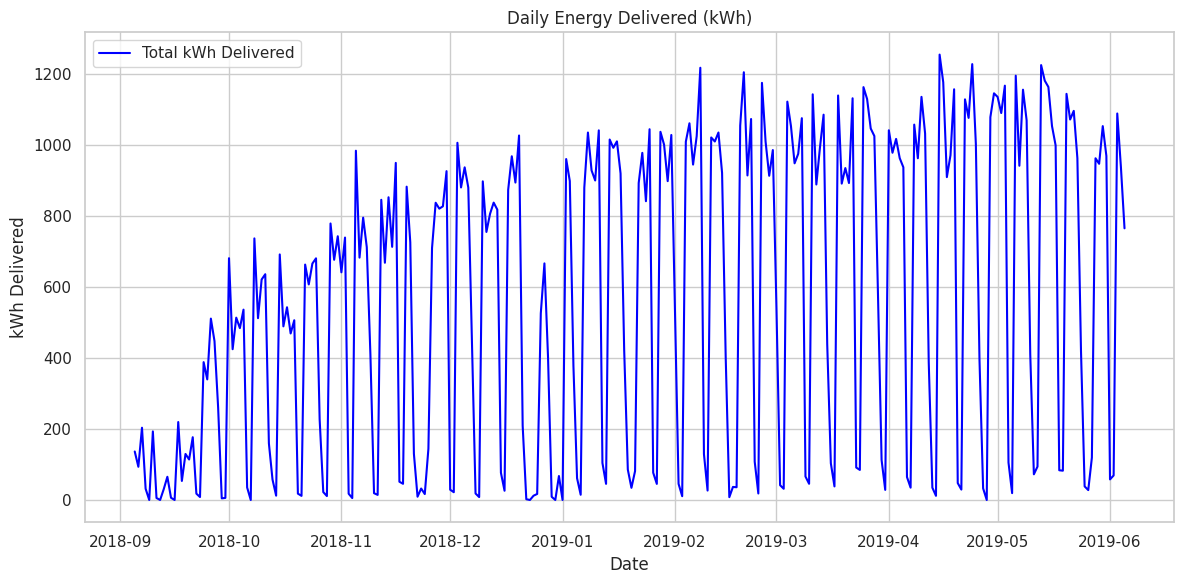

In [ ]:
# Daily Aggregation Chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_data, x='connectionTime', y='kWhDelivered', label='Total kWh Delivered', color='blue')
plt.title('Daily Energy Delivered (kWh)')
plt.xlabel('Date')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

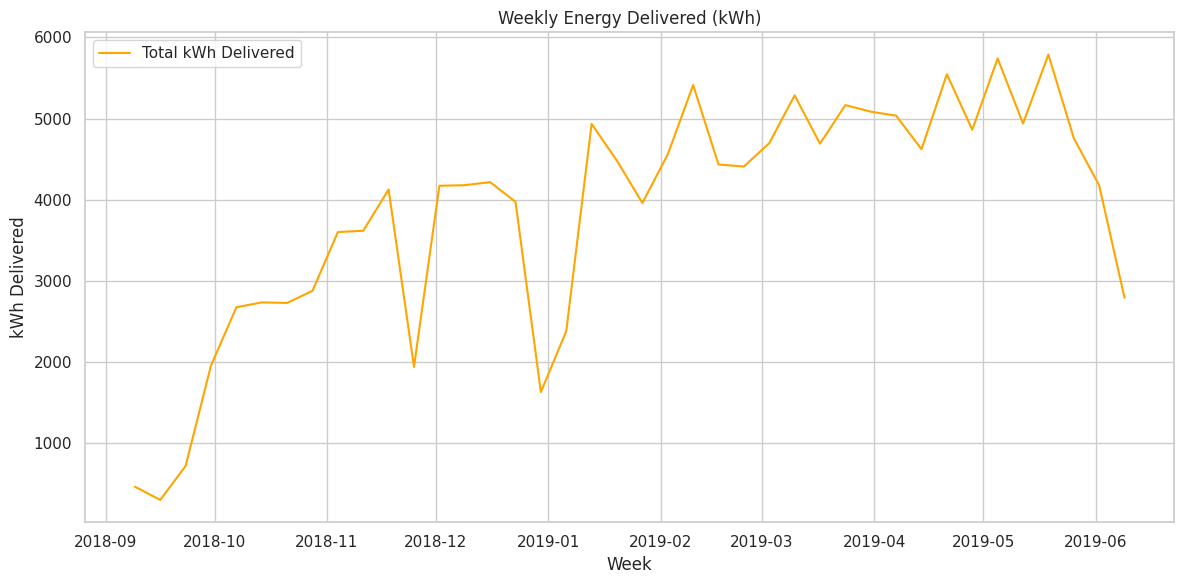

In [ ]:
# Weekly Aggregation Chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_data, x='connectionTime', y='kWhDelivered', label='Total kWh Delivered', color='orange')
plt.title('Weekly Energy Delivered (kWh)')
plt.xlabel('Week')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

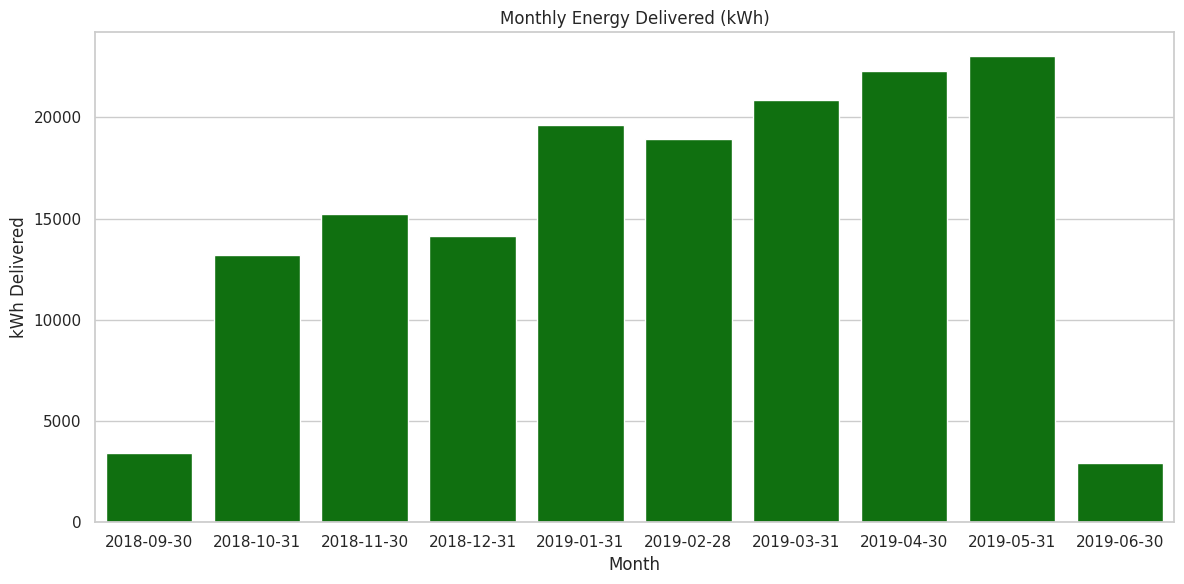

In [ ]:
# Monthly Aggregation Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_data, x='connectionTime', y='kWhDelivered', color='green')
plt.title('Monthly Energy Delivered (kWh)')
plt.xlabel('Month')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

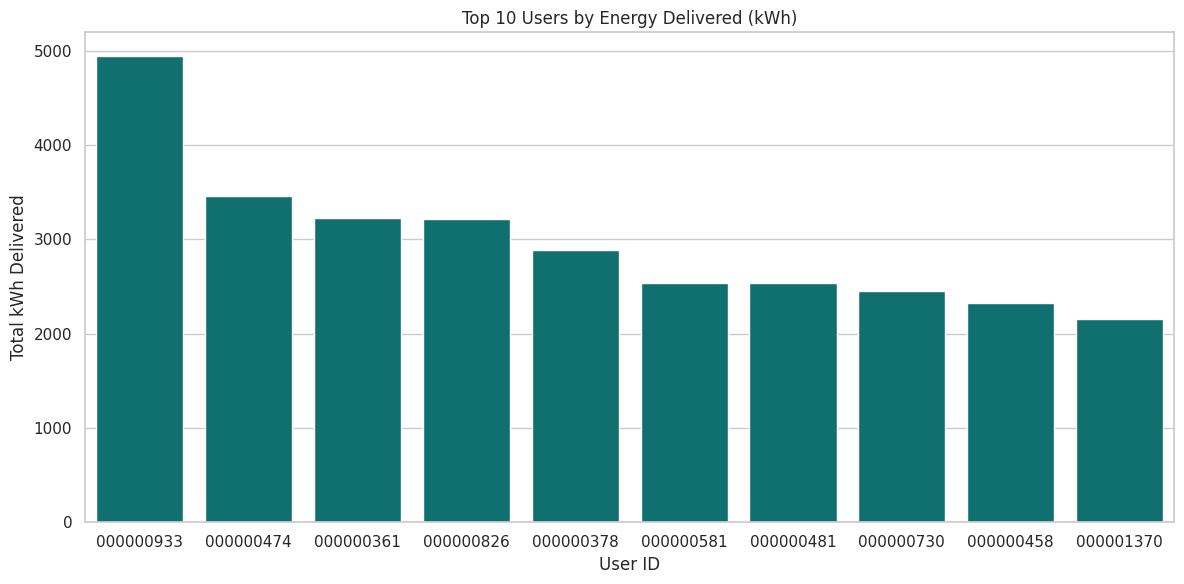

In [ ]:
# User-Specific Energy Demand
plt.figure(figsize=(12, 6))
sns.barplot(data=user_data.sort_values(by='kWhDelivered', ascending=False).head(10), x='userID', y='kWhDelivered', color='teal')
plt.title('Top 10 Users by Energy Delivered (kWh)')
plt.xlabel('User ID')
plt.ylabel('Total kWh Delivered')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

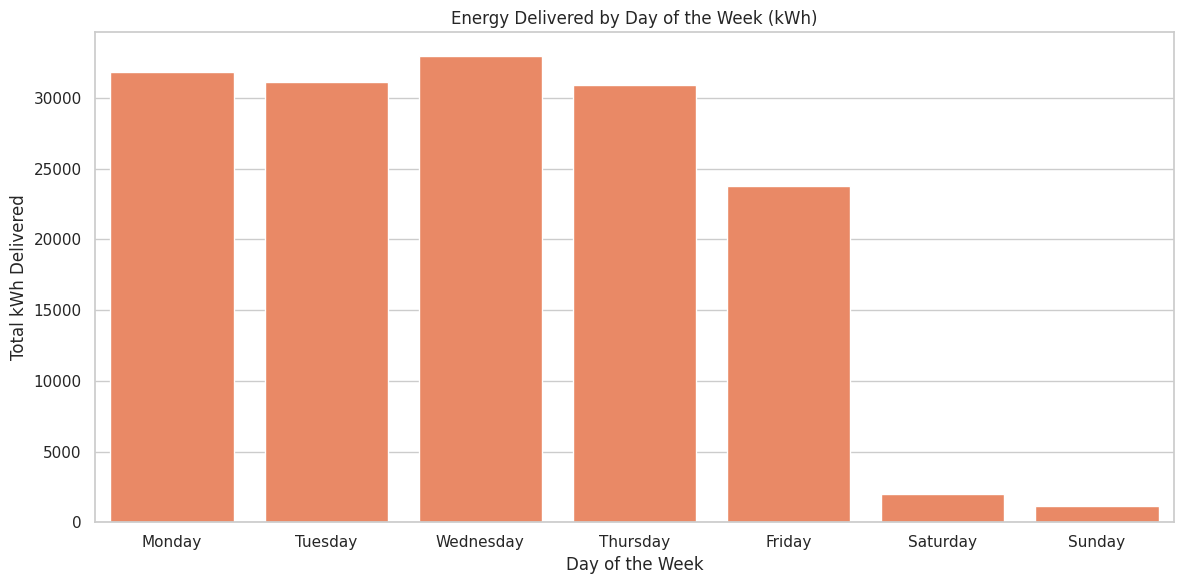

In [ ]:
# Day of the Week Analysis
plt.figure(figsize=(12, 6))
sns.barplot(data=day_of_week_data, x='dayOfWeek', y='kWhDelivered', color='coral')
plt.title('Energy Delivered by Day of the Week (kWh)')
plt.xlabel('Day of the Week')
plt.ylabel('Total kWh Delivered')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

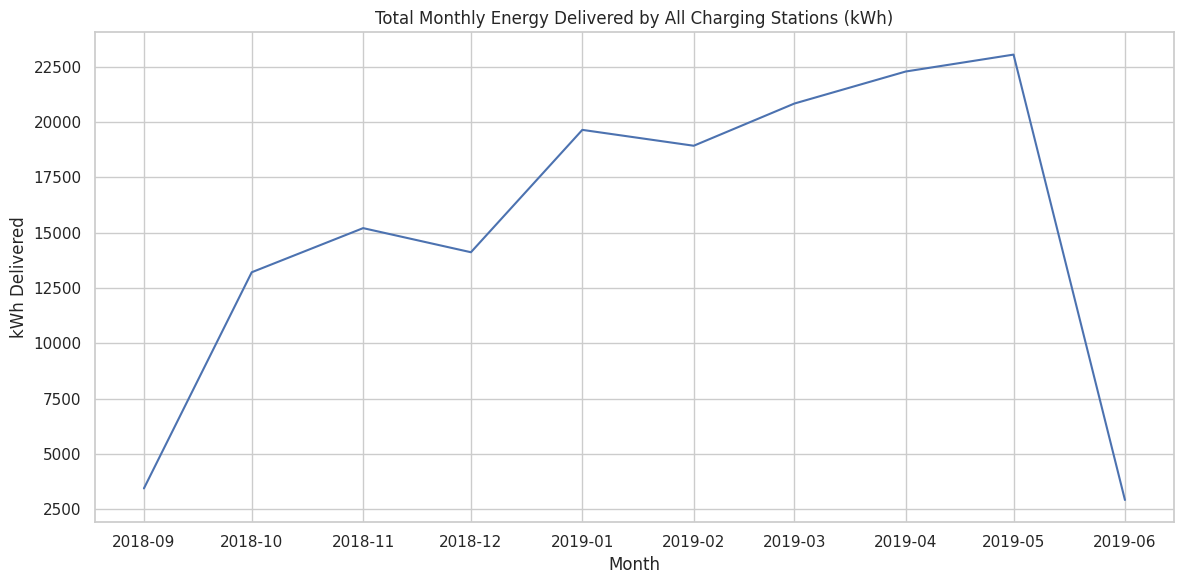

In [ ]:
# Aggregate data for total energy delivered by month
total_monthly_data = df.groupby(df['connectionTime'].dt.to_period('M')).agg({'kWhDelivered': 'sum'}).reset_index()
total_monthly_data['connectionTime'] = total_monthly_data['connectionTime'].dt.to_timestamp()

# Plot total monthly energy delivered
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_monthly_data, x='connectionTime', y='kWhDelivered')
plt.title('Total Monthly Energy Delivered by All Charging Stations (kWh)')
plt.xlabel('Month')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

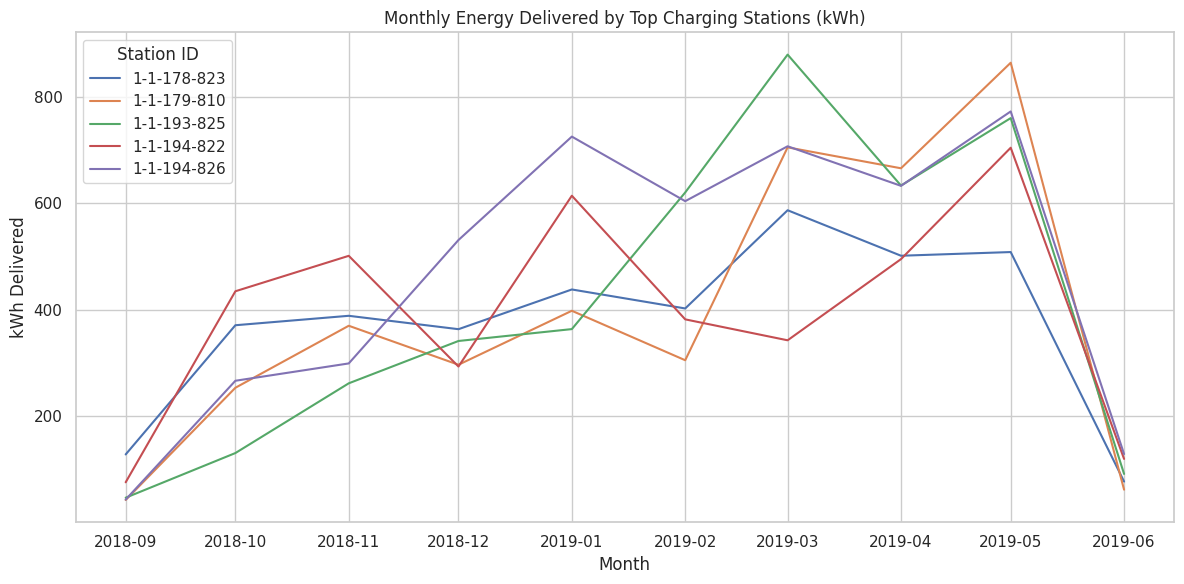

In [ ]:
# Get the top 5 stations based on total kWh delivered
top_stations = df.groupby('stationID').agg({'kWhDelivered': 'sum'}).nlargest(5, 'kWhDelivered').index

# Filter the data for only the top stations
top_station_monthly_data = df[df['stationID'].isin(top_stations)].groupby([df['connectionTime'].dt.to_period('M'), 'stationID']).agg({'kWhDelivered': 'sum'}).reset_index()
top_station_monthly_data['connectionTime'] = top_station_monthly_data['connectionTime'].dt.to_timestamp()

# Plotting for top stations
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_station_monthly_data, x='connectionTime', y='kWhDelivered', hue='stationID')
plt.title('Monthly Energy Delivered by Top Charging Stations (kWh)')
plt.xlabel('Month')
plt.ylabel('kWh Delivered')
plt.xticks(rotation=0)
plt.legend(title='Station ID')
plt.tight_layout()
plt.show()

In [ ]:
df

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,end,start,sessionDuration,chargingDuration,avgPowerDelivered,hourOfDay,dayOfWeek,month
1,5c36621bf9af8b4639a8e0b5,0001,2018-09-05 11:08:09,2018-09-05 14:09:02,NaT,7.114,1_1_179_794_2018-09-05 11:08:08.945820,0001,AG-3F20,1-1-179-794,America/Los_Angeles,000000333,2024-10-11 11:37:00,2010-01-01 11:37:00,3.014722,NaN,0.000000,11,2,9
2,5c36621bf9af8b4639a8e0b6,0001,2018-09-05 12:35:14,2018-09-06 00:30:12,NaT,11.774,1_1_179_797_2018-09-05 12:35:14.070250,0001,AG-3F23,1-1-179-797,America/Los_Angeles,000000371,2024-10-11 11:37:00,2010-01-01 11:37:00,11.916111,NaN,0.000000,12,2,9
3,5c36621bf9af8b4639a8e0b7,0001,2018-09-05 12:51:31,2018-09-05 22:32:58,NaT,6.280,1_1_179_781_2018-09-05 12:51:31.050539,0001,AG-3F31,1-1-179-781,America/Los_Angeles,000000405,2024-10-11 11:37:00,2010-01-01 11:37:00,9.690833,NaN,0.000000,12,2,9
4,5c36621bf9af8b4639a8e0b8,0001,2018-09-05 13:08:28,2018-09-05 23:32:52,NaT,7.022,1_1_179_787_2018-09-05 13:08:27.901538,0001,AG-3F16,1-1-179-787,America/Los_Angeles,000000368,2024-10-11 11:37:00,2010-01-01 11:37:00,10.406667,NaN,0.000000,13,2,9
5,5c36621bf9af8b4639a8e0b9,0001,2018-09-05 13:10:14,2018-09-05 22:21:44,NaT,13.282,1_1_179_798_2018-09-05 13:10:13.879377,0001,AG-3F18,1-1-179-798,America/Los_Angeles,000000334,2024-10-11 11:37:00,2010-01-01 11:37:00,9.191667,NaN,0.000000,13,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12194,5d0d76d7f9af8b5e7728d3de,0001,2019-06-05 14:15:21,2019-06-05 23:08:43,2019-06-05 20:52:24,37.048,1_1_191_795_2019-06-05 14:15:20.698722,0001,AG-4F51,1-1-191-795,America/Los_Angeles,000001370,2024-10-11 11:37:00,2010-01-01 11:37:00,8.889444,6.617500,5.598489,14,2,6
12195,5d0d76d7f9af8b5e7728d3df,0001,2019-06-05 14:19:24,2019-06-05 23:35:03,2019-06-05 22:49:14,18.700,1_1_191_811_2019-06-05 14:19:24.384705,0001,AG-4F42,1-1-191-811,America/Los_Angeles,000000581,2024-10-11 11:37:00,2010-01-01 11:37:00,9.260833,8.497222,2.200719,14,2,6
12196,5d0d76d7f9af8b5e7728d3e0,0001,2019-06-05 14:19:36,2019-06-05 23:45:26,2019-06-05 23:42:46,37.648,1_1_191_792_2019-06-05 14:19:36.291454,0001,AG-4F37,1-1-191-792,America/Los_Angeles,000002361,2024-10-11 11:37:00,2010-01-01 11:37:00,9.430556,9.386111,4.011033,14,2,6
12197,5d0d76d7f9af8b5e7728d3e1,0001,2019-06-05 14:20:16,2019-06-05 23:35:11,2019-06-05 20:35:47,38.759,1_1_191_812_2019-06-05 14:20:16.297295,0001,AG-4F46,1-1-191-812,America/Los_Angeles,000000531,2024-10-11 11:37:00,2010-01-01 11:37:00,9.248611,6.258611,6.192908,14,2,6


In [ ]:
df['spaceID'].unique()

array(['AG-3F20', 'AG-3F23', 'AG-3F31', 'AG-3F16', 'AG-3F18', 'AG-3F27',
       'AG-3F28', 'AG-3F22', 'AG-3F21', 'AG-3F17', 'AG-3F26', 'AG-3F19',
       'AG-3F24', 'AG-3F30', 'AG-3F25', 'AG-3F33', 'AG-3F29', 'AG-3F15',
       'AG-1F08', 'AG-1F10', 'AG-1F07', 'AG-1F09', 'AG-3F32', 'AG-1F12',
       'AG-4F48', 'AG-4F44', 'AG-1F06', 'AG-1F04', 'AG-1F03', 'AG-4F43',
       'AG-4F45', 'AG-1F01', 'AG-4F47', 'AG-4F50', 'AG-4F37', 'AG-4F35',
       'AG-4F36', 'AG-1F11', 'AG-4F51', 'AG-4F49', 'AG-4F42', 'AG-1F05',
       'AG-1F13', 'AG-1F02', 'AG-1F14', 'AG-4F34', 'AG-4F40', 'AG-4F39',
       'AG-4F38', 'AG-4F46', 'AG-4F41', 'AG-4F52'], dtype=object)

In [ ]:
df['chargingDuration'].describe()

,chargingDuration
count,10090.000000
mean,4.082146
std,2.369402
min,-0.016111
25%,2.264792
50%,3.669583
75%,5.321458
max,25.280556


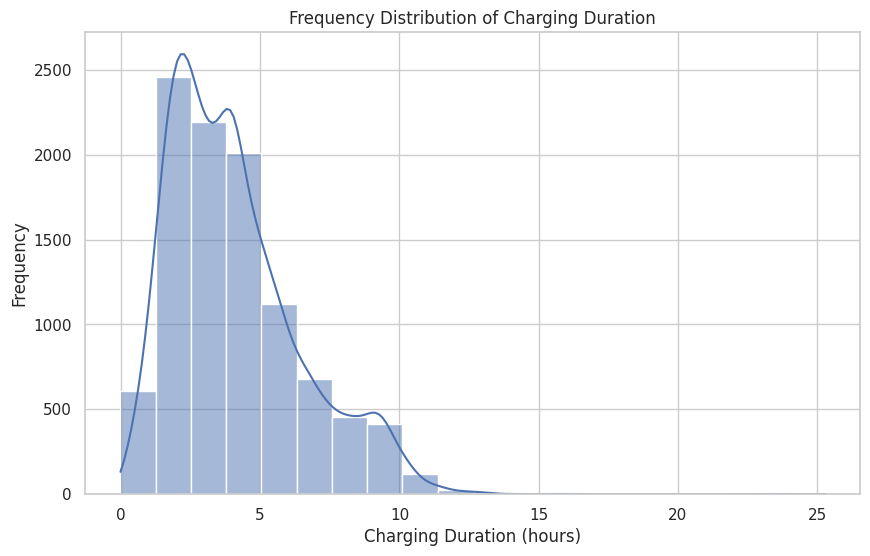

In [ ]:
# Create a histogram to visualize the frequency distribution
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(df['chargingDuration'], bins=20, kde=True)  # Adjust bins and kde as needed
plt.title('Frequency Distribution of Charging Duration')
plt.xlabel('Charging Duration (hours)')
plt.ylabel('Frequency')
plt.show()

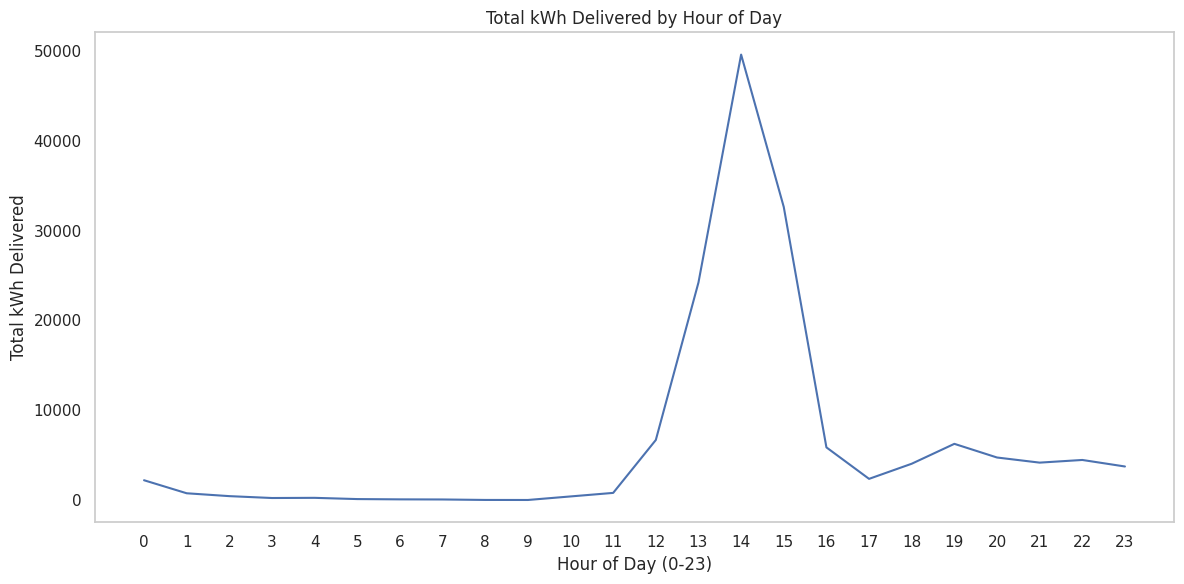

In [ ]:
# Aggregate kWh delivered by hour of day
kWh_hour_of_day = df.groupby('hourOfDay').agg({'kWhDelivered': 'sum'}).reset_index()

# Plotting kWh delivered against hour of day
plt.figure(figsize=(12, 6))
sns.lineplot(data=kWh_hour_of_day, x='hourOfDay', y='kWhDelivered')
plt.title('Total kWh Delivered by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Total kWh Delivered')
plt.xticks(range(0, 24))  # Set x-ticks to represent full hours
plt.grid()
plt.tight_layout()
plt.show()

